In [1]:
import itertools
import pandas as pd
import numpy as np
np.random.seed(42)
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import load_everything

dark_mode = False
if dark_mode:
    COLOR = '#bbccd5'
    BG = '#23272a'
    # print(mpl.rcParams.keys()) # see all params
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR
    mpl.rcParams['figure.facecolor'] = BG
    mpl.rcParams['figure.figsize'] = [16, 9]


In [2]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Load the Dataset

In [3]:
# the dataset contains all of the metadata test and train sets are self explanatory 
# no shuffling is required this is all done in the loader. indexes match between the dataset and x_train etc
# to index for the test set do dataset[len(x_train):]
dataset, (x_train, x_test, y_train, y_test) = load_everything(os.path.join('..', 'datasets'))

## GPU Setup

In [4]:
# Tensorflow Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing


# Setup the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.0
Num GPUs Available:  1


## CNN

There are 6708 images in the dataset
There are 1000 fire images
There are 5708 non-fire images
Index(['img_name', 'img_source', 'fire', 'pos_y', 'pos_x', 'wind_direction',
       'wind_strength'],
      dtype='object')


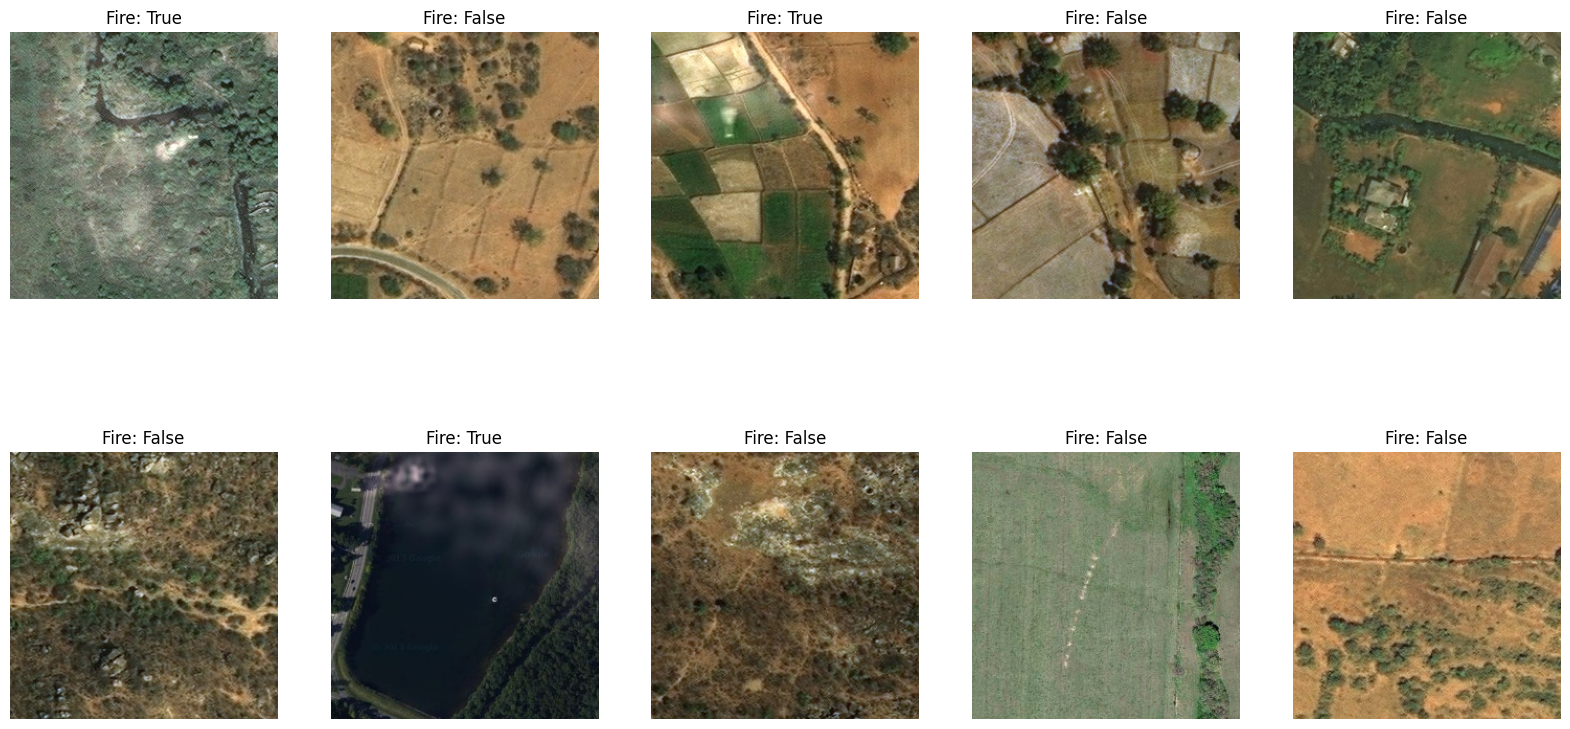

In [5]:
print(f'There are {len(dataset)} images in the dataset')
print(f'There are {len(dataset[dataset["fire"] == 1])} fire images')
print(f'There are {len(dataset[dataset["fire"] == 0])} non-fire images')

#All the columns in the dataset
print(dataset.columns)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_train[i])
    ax[i // 5, i % 5].set_title(f'Fire: {y_train[i]}')
    ax[i // 5, i % 5].axis('off')


In [6]:
# Data Augmentation
# Add more fire images to the dataset by flipping the images and adding them to the dataset 
x_train_fire = x_train[y_train == 1]
x_train_fire = np.array([cv2.flip(img, 1) for img in x_train_fire])
y_train_fire = np.ones(len(x_train_fire))
x_train = np.concatenate((x_train, x_train_fire))
y_train = np.concatenate((y_train, y_train_fire))

# print the new number of fire images in x_train and y_train
print(f'There are {len(x_train[y_train == 1])} fire images')
print(f'There are {len(x_train[y_train == 0])} non-fire images')


There are 1526 fire images
There are 4268 non-fire images


In [7]:
# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

x_train shape: (5794, 224, 224, 3)
x_test shape: (1677, 224, 224, 3)


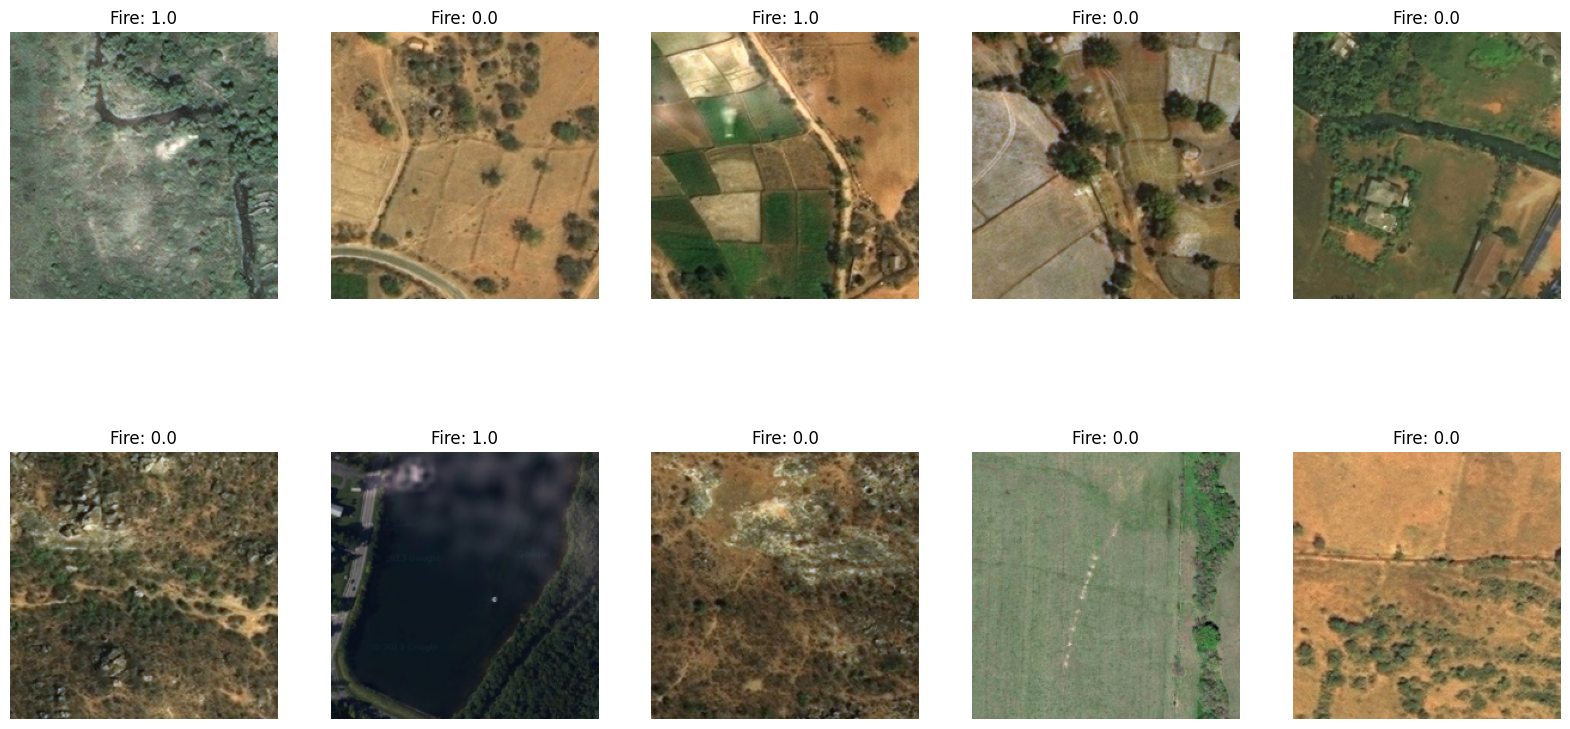

In [8]:
# Change the shape of the images to 224, 224, 3 for MobileNetV2
x_train = np.array([cv2.resize(img, (224, 224)) for img in x_train])
x_test = np.array([cv2.resize(img, (224, 224)) for img in x_test])
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

# Display some random resized images with cv2 imshow
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_train[i])
    ax[i // 5, i % 5].set_title(f'Fire: {y_train[i]}')
    ax[i // 5, i % 5].axis('off')


In [9]:
# Preprocess the images
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x) 

# Implement weight decay
x = layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

# Apply batch normalization
x = layers.BatchNormalization()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
predictions = layers.Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Check the final model architecture
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=55, validation_data=(x_test, y_test))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# Plot the training and validation loss + accuracy
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
 
# Save the model
model.save('fire_detector.h5')

# Save the graph figures
fig.savefig('loss.png')

In [ ]:
# Evaluate the model on the test data using `evaluate`
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
print("Evaluate on test data")

# Predict on the first 5 test images.
predictions = model.predict(x_test[:5])

# Print our model's predictions.
print(np.round(predictions))

# Check our predictions against the ground truths.
print(y_test[:5])

# Show the confusion matrix and other metrics
y_pred = np.round(model.predict(x_test))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt='d')

# Save the confusion matrix figure
plt.savefig('confusion_matrix.png')

# Q: What figures would help us to evaluate the model?
# A: The confusion matrix and the classification report

# Print classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the ROC curve figure
plt.savefig('roc_curve.png')


In [ ]:
#Plot the Precision-Recall Curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = model.predict(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 0]
# predict class values
yhat = (model.predict(x_test) > 0.5).astype("int32")
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# Save the Precision-Recall Curve figure
plt.savefig('precision_recall_curve.png')


# SVM and Random Forest

In [ ]:
# Setup for SVM and Random Forest models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
# Reduce dimensionality of data using PCA to 2 dimensions for the SVM model and the Random Forest model
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(np.reshape(x_train, (len(x_train), -1)))
x_test_pca = pca.fit_transform(np.reshape(x_test, (len(x_test), -1)))

# SVM model
svm = SVC()

# Fit the SVM model to the training data
svm.fit(x_train_pca, y_train)

# Make predictions on the test data
y_pred = svm.predict(x_test_pca)

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Random Forest model
rf = RandomForestClassifier()

# Fit the Random Forest model to the training data
rf.fit(x_train_pca, y_train)

# Make predictions on the test data
y_pred = rf.predict(x_test_pca)

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred))

# GridSearchCV for SVM model
# Create the parameter grid based on the results of random search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Create a based model
svm = SVC()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(x_train_pca, y_train)

# Print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_index_)

# Make predictions on the test data
y_pred = grid_search.predict(x_test_pca)

# Print the accuracy score
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
def model_save(model, name, src = ''):
    if not src:
        src = os.path.abspath('')
    model_path = os.path.join(src, f'{name}.h5')
    model.save(model_path, save_format='h5')

def get_random_fire_img():
    dataset_base_path = os.path.join('../datasets', 'generated')
    labels = np.unique(dataset['fire'])
    img_sample = dataset[dataset['fire'] == True].sample(1)
    img_name = f'{img_sample["img_name"].iloc[0]}.jpg'
    img_path = os.path.join(dataset_base_path, img_name)
    img = plt.imread(img_path)
    return img

class IWFAgent:
    def __init__(self, model_path, shape):
        self.shape = shape
        self.learned_model = tf.keras.models.load_model(model_path)
    
    def reshape_data(self, data):
        return np.array(cv2.resize(data, self.shape))
    
    def classify(self, img):
#         loss, acc = learned_model.evaluate(img, test_labels, verbose=2)
#         print(f'Restored model, accuracy: {(100*acc):5.2f}%')
        reshaped_img = self.reshape_data(img)
        print(self.learned_model.predict(reshaped_img[None,:,:]))


test_img = get_random_fire_img()
plt.imshow(test_img)
model_save(model, 'model')

model_path = './model.h5' 
shape = (244, 244)
a = IWFAgent(model_path, shape)
pred = a.classify(test_img)
# https://www.tensorflow.org/tutorials/keras/save_and_load
# OTHER FORMATS ^^^^